In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 500)
import seaborn as sns
import statsmodels.formula.api as sm
import plotly.graph_objects as go
import datetime
from utils import get_human_timestamp
import plotly
import plotly.graph_objs as go
import plotly.express as px
from sklearn.linear_model import LinearRegression
from plotly.subplots import make_subplots


# Попробуем найти зависимость best_bid - best_ask ~ F(f, S)

In [2]:
df = pd.read_csv(f"./datasets/deribit_options_chain_2022-12-01_OPTIONS.csv")
data = df.copy()

In [38]:
single = data[data["expiration"] == data.sample(1)["expiration"].iloc[0]].copy()
single = single[single["symbol"].str.startswith("ETH")]
single["human_timestamp"] = single["timestamp"].apply(get_human_timestamp)
single["ask_min_bid"] = single["ask_price"] - single["bid_price"]

In [59]:
single

,exchange,symbol,timestamp,local_timestamp,type,strike_price,expiration,open_interest,last_price,bid_price,bid_amount,bid_iv,ask_price,ask_amount,ask_iv,mark_price,mark_iv,underlying_index,underlying_price,delta,gamma,vega,theta,rho,human_timestamp,ask_min_bid
5,deribit,ETH-31MAR23-1300-C,1669852800014000,1669852800019061,call,1300,1680249600000000,3699.0,0.1660,0.1705,5.0,76.67,0.1725,46.0,77.56,0.1715,77.12,ETH-31MAR23,1288.31,0.57965,0.00069,2.89203,-0.92675,1.73348,2022-12-01 03:00:00.014000,0.0020
8,deribit,ETH-31MAR23-1300-P,1669852800017000,1669852800023383,put,1300,1680249600000000,2670.0,0.2210,0.1790,70.0,76.41,0.1820,47.0,77.75,0.1806,77.12,ETH-31MAR23,1288.31,-0.42035,0.00069,2.89203,-0.92675,-2.55237,2022-12-01 03:00:00.017000,0.0030
13,deribit,ETH-31MAR23-1300-C,1669852800017000,1669852800024419,call,1300,1680249600000000,3699.0,0.1660,0.1705,5.0,76.67,0.1725,88.0,77.56,0.1715,77.12,ETH-31MAR23,1288.31,0.57965,0.00069,2.89203,-0.92675,1.73348,2022-12-01 03:00:00.017000,0.0020
31,deribit,ETH-31MAR23-1000-P,1669852800280000,1669852800288711,put,1000,1680249600000000,18415.0,0.0825,0.0815,26.0,85.12,0.0830,21.0,86.00,0.0823,85.56,ETH-31MAR23,1288.31,-0.22324,0.00047,2.20862,-0.78519,-1.29750,2022-12-01 03:00:00.280000,0.0015
56,deribit,ETH-31MAR23-9000-P,1669852800633000,1669852800639266,put,9000,1680249600000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9869,117.49,ETH-31MAR23,1288.31,-0.99452,0.00002,0.11597,-0.05662,-29.65214,2022-12-01 03:00:00.633000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22492136,deribit,ETH-31MAR23-900-P,1669939199495000,1669939199507580,put,900,1680249600000000,7266.0,0.0612,0.0605,19.0,87.95,0.0615,40.0,88.63,0.0609,88.26,ETH-31MAR23,1272.52,-0.17395,0.00040,1.86846,-0.69095,-0.97731,2022-12-02 02:59:59.495000,0.0010
22492138,deribit,ETH-31MAR23-1000-P,1669939199492000,1669939199509094,put,1000,1680249600000000,18425.0,0.0865,0.0825,23.0,83.85,0.0840,39.0,84.72,0.0832,84.24,ETH-31MAR23,1272.52,-0.22930,0.00049,2.20559,-0.77851,-1.30002,2022-12-02 02:59:59.492000,0.0015
22492153,deribit,ETH-31MAR23-1200-C,1669939199491000,1669939199510130,call,1200,1680249600000000,3533.0,0.2070,0.2005,44.0,77.58,0.2040,109.0,79.21,0.2021,78.35,ETH-31MAR23,1272.57,0.63873,0.00066,2.72553,-0.89469,1.81643,2022-12-02 02:59:59.491000,0.0035
22492154,deribit,ETH-31MAR23-1000-C,1669939199496000,1669939199510143,call,1000,1680249600000000,2725.0,0.3020,0.2965,37.0,83.76,0.2995,83.0,85.49,0.2974,84.24,ETH-31MAR23,1272.52,0.77070,0.00049,2.20559,-0.77851,1.96938,2022-12-02 02:59:59.496000,0.0030


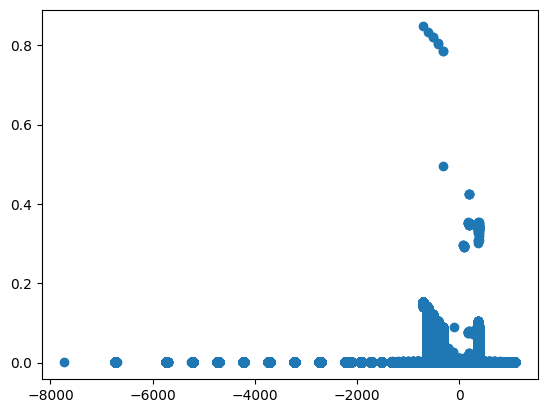

In [58]:
# sample  = single.sample(1000)
plt.scatter(single["underlying_price"] - single["strike_price"], single["ask_min_bid"])

In [29]:
single.ask_min_bid.value_counts()

0.0010    9674
0.0015    3557
0.0005    3018
0.0020     305
0.0025      24
0.0030      14
0.0025       2
0.0030       2
Name: ask_min_bid, dtype: int64

In [28]:
single.

,exchange,symbol,timestamp,local_timestamp,type,strike_price,expiration,open_interest,last_price,bid_price,bid_amount,bid_iv,ask_price,ask_amount,ask_iv,mark_price,mark_iv,underlying_index,underlying_price,delta,gamma,vega,theta,rho,human_timestamp,ask_min_bid
528,deribit,ETH-31MAR23-2100-C,1669852802647000,1669852802673790,call,2100,1680249600000000,14086.0,0.0315,0.0335,42.0,74.21,0.0345,61.0,74.88,0.034,74.55,ETH-31MAR23,1288.30,0.17682,0.00047,1.91934,-0.59451,0.60660,2022-12-01 03:00:02.647000,0.001
1793,deribit,ETH-31MAR23-2100-C,1669852807684000,1669852807693364,call,2100,1680249600000000,14086.0,0.0315,0.0335,42.0,74.21,0.0345,61.0,74.88,0.034,74.55,ETH-31MAR23,1288.27,0.17681,0.00047,1.91921,-0.59447,0.60655,2022-12-01 03:00:07.684000,0.001
3357,deribit,ETH-31MAR23-2100-C,1669852812717000,1669852812742339,call,2100,1680249600000000,14086.0,0.0315,0.0335,42.0,74.24,0.0345,61.0,74.91,0.034,74.55,ETH-31MAR23,1287.91,0.17664,0.00047,1.91753,-0.59395,0.60584,2022-12-01 03:00:12.717000,0.001
4535,deribit,ETH-31MAR23-2100-C,1669852818759000,1669852818774849,call,2100,1680249600000000,14086.0,0.0315,0.0335,42.0,74.24,0.0345,61.0,74.91,0.034,74.55,ETH-31MAR23,1287.93,0.17667,0.00047,1.91773,-0.59404,0.60592,2022-12-01 03:00:18.759000,0.001
5816,deribit,ETH-31MAR23-2100-C,1669852823801000,1669852823816528,call,2100,1680249600000000,14086.0,0.0315,0.0335,42.0,74.25,0.0345,61.0,74.92,0.034,74.55,ETH-31MAR23,1287.82,0.17663,0.00047,1.91728,-0.59392,0.60573,2022-12-01 03:00:23.801000,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22485961,deribit,ETH-31MAR23-2100-C,1669939174425000,1669939174432994,call,2100,1680249600000000,15189.0,0.0310,0.0310,140.0,73.98,0.0330,55.0,75.37,0.032,74.70,ETH-31MAR23,1272.29,0.16860,0.00046,1.83114,-0.57310,0.56811,2022-12-02 02:59:34.425000,0.002
22487590,deribit,ETH-31MAR23-2100-C,1669939180360000,1669939180374572,call,2100,1680249600000000,15189.0,0.0310,0.0310,140.0,73.98,0.0330,55.0,75.37,0.032,74.70,ETH-31MAR23,1272.32,0.16860,0.00046,1.83122,-0.57311,0.56814,2022-12-02 02:59:40.360000,0.002
22488931,deribit,ETH-31MAR23-2100-C,1669939186402000,1669939186417340,call,2100,1680249600000000,15189.0,0.0310,0.0310,140.0,73.98,0.0330,55.0,75.37,0.032,74.69,ETH-31MAR23,1272.34,0.16860,0.00046,1.83124,-0.57310,0.56815,2022-12-02 02:59:46.402000,0.002
22490422,deribit,ETH-31MAR23-2100-C,1669939191443000,1669939191462231,call,2100,1680249600000000,15189.0,0.0310,0.0310,140.0,73.98,0.0330,55.0,75.37,0.032,74.69,ETH-31MAR23,1272.36,0.16860,0.00046,1.83128,-0.57310,0.56817,2022-12-02 02:59:51.443000,0.002
